## Transformer Designer - Power

References
* [Transformer Design and Manufacturing Manual - Wolpert](http://www.vintagewindings.com/gen%20pop/8299543VW8335/TransDesign%201/Wolpert-PowerTransformers.pdf)
* [Engineering a Transformer - Stancor](http://www.vintagewindings.com/gen%20pop/8299543VW8335/TransDesign%202/TransformerEngineering%20Stancor-1945.pdf)
* [Electronic Transformers and Circuits - Lee](www.tubebooks.org/books/lee_1955_electronic_transformers_and_circuits.pdf)
* [Flux Lines to Tesla](http://www.translatorscafe.com/cafe/EN/units-converter/magnetic-flux-density/10-1/line%2Finch%C2%B2-tesla/)

### Using Wolpert
<hr>
#### Equations without losses

$$\frac{E_s}{E_p} = \frac{N_s}{N_p}$$

$$\frac{I_s}{I_p} = \frac{N_P}{N_S}$$


$E_s$ = Secondary voltage<br>
$E_p$ = Primary voltage<br>
$I_s$ = Secondary current<br>
$I_p$ = Primary voltage<br>
$N_s$ = Secondary turns<br>
$N_p$ = Primary turns<br>

$$VA = E_p * I_p = E_s * I_s$$

<hr>
#### Equations with losses

$$VA = E_s * I_s$$

$$I_p = \frac{VA * efficiency}{E_p}$$

$$Area_{effective} = Area_{core} * stackingFactor$$

$Area_{effective}$ = core area (tongue width * stack height)<br>
stackingFactor = use 0.92 for 1x1 interleave and 0.95 for butt stack<br>

$$N_p = \frac{E_p * 10^8}{4.44 * B * A * F}$$

4.44 is a constant for sine wave operation<br>
B = flux density in $\frac{lines}{inch^2}$<br>
A = $Area_{effective}$<br>
F = line frequency<br>

$$N_s = \frac{N_p}{E_p} * lossFactor * E_s$$

lossFactor = factor to adjust turns to compensate for losses

$$T_{rise} = \frac{totalLoss}{0.1*{(\frac{weight}{1.073})}^\frac{2}{3}}$$

$$\%_{regulation} = \frac{E_{noLoad} - E_{fullLoad}}{E_{fullLoad}} * 100\%$$


#### Calculation Steps
* Sum desired secondary VAs, voltage * current
* Calculate primary current including efficiency
* Calculate effective core area using stacking factor
* Calculate primary turns
* Calculate secondary turns
* Calculate primary and secondary wire diameters
* Calculate primary and secondary layer count
* Loop
 * Calculate all windings mean path length
 * Calculate all windings resistance
 * Calculate all winding voltage drops
 * Find secondary turn count that minimizes abs($V_{desired} - V_{out}$)
* Calculate winding weight
* Calculate transformer weight including extras: lead wire, bells, brackets
* Calculate temperature rise above ambient, ($T_{ambient} + T_{rise}$) < 105C, Wolpert p25
    
#### Additional Considerations
* Choice of flux density affects primary turn count, which results in an integer
 * Voltage ratios are a fractional number of 2 integer divisions
 * By changing the flux density, you can minutely alter the secondary output voltages
 * The fluxFind() method scans flux densities and returns density with minimal output error
 * While fluxFind() finds optimal density, you may opt for lower density to avoid saturation when using recycled, or unknown, laminations
* Lowering circularMilsPerAmp results in smaller gauge wire with higher operating temperature. The default value of 800 is fairly conservative. If you're design doesn't quite fit, lower circularMilsPerAmp and see what happens to bobbin fill percentage and temperature rise 
* 29M6 GOSS laminations have coreLoss of 0.66 watts/lb, see Wolpert P24. Foster rep loosely stated their non-oriented lamination loss is 5W/lb at 13kGauss. You can see this in data sheets from AK Steel of ATI. In summary, non-oriented steel will have higher core losses hence higher temperature rise. However, they also have lower inrush current. If you're recycling laminations, chances are they are not oriented. You also don't know saturation, so choose a low flux density, which will increase turns and fill your bobbin.  

In [2]:
%matplotlib notebook
import Winding,Transformer
import matplotlib.pyplot as plt
import numpy as np
import math

Here are the default transformer parameter values

    laminationVA           = lamva      
    circularMilsPerAmp     = 800.0
    coreLoss               = 0.66  # watts/lbs
    efficiency             = 0.90  # 1/1.11 in wolpert p10
                                   # estimate w/o calculating primary leakage inductance
    lineFrequency          = 60.0       
    stackingFactor         = 0.92  # stacking factor wolpert p11 
                                   #  0.92 1x1 interleave, 0.95 butt stack
    lossFactor             = 0.95  # 1/1.05 in wolpert p11
    isolationThickness     = 0.003 # 1 mil kapton
    wrappingThickness      = 0.015      
    weightExtra            = 1.15  # percentage of extra: bells, brackets, screws
    insulationLayers       = 3
    

In [10]:
# Simple 12V 3A filament transformer

%reload_ext autoreload

primary      = Winding.Winding('p',115.0,0.0)
secondary    = Winding.Winding('s', 12.6,3.0,taps=[50])

t = Transformer.Transformer([primary,secondary],50,have=1)

t.circularMilsPerAmp = 600

#t.fluxDensity = 87000

t.fluxDensity = t.fluxFind(bmax=90000)

t.compute()
t.report()
t.fluxTable()


Requirements
  Primary              = 115.0 V
  Secondary            =  12.6 V @ 3.000 A Taps 50
  Size                 = EI-1
  AWG Selection        = 40 37 34 32 31 27 24 22 20 18 15 
  VA Selection         = 50.0 VA

Transformer
  VA Computed          = 37.8 VA
  Flux Density         = 87000 lines, 13485 gauss
  Circular Mils/Amp    = 600
  Weight               = 2.6lbs
  Loss                 = 2.6W
  Temp Rise            = 14C

Lamination
  Size                 = EI-1
  Stack Height         = 1.25
  Stacking Factor      = 0.920
  Core Area            = 1.250 in*in
  Core Area Effective  = 1.150 in*in
  Window Height        = 0.5
  Window Length        = 1.5

Windings
  Type                  Primary     Secondary   
  Voltage V             115.0       12.6        
  Current A             0.4         3.0         
  Turns                 431         49          
  Layers                7           3           
  Turns/layer           62          22          
  AWG                   24

In [14]:
print t.gcode()

(-----------------------------------------------------------)
(-- Requirements -------------------------------------------)
(  Primary              = 115.0 V                           )
(  Secondary            =  12.6 V @ 3.000 A Taps 50         )
(  Size                 = EI-1                              )
(  AWG Selection        = 40 37 34 32 31 27 24 22 20 18 15  )
(  VA Selection         =  50.0 VA                          )

(-- setup -------------------------------------)
( inches, work offset 54, absolute, linear 125%)
G20 G54 G90
G1 F125

(-- winding -  115.0V Primary    --------------)
( load #24 AWG wire                            )
( winding  368 turns, fill last True           )
( move to 0.0                                  )
( wind leadin                                  )
M0
X1.3330     Y62.0000        ( right            )
X0.0000     Y124.0000       ( left             )
X1.3330     Y186.0000       ( right            )
X0.0000     Y248.0000       ( left             )
X1

In [ ]:
# Simple 12V filament transformer
# now use fluxfind

%reload_ext autoreload

primary      = Winding.Winding('p',115.0,0.0)
secondary    = Winding.Winding('s', 12.6,3.0,taps=[50])

t = Transformer.Transformer([primary,secondary],50,have=0)

t.fluxDensity = t.fluxFind(bmax=100000,inc=100) # this scans through flux densities and finds minimal error for output voltage
t.compute()
t.report()

In [ ]:
# Simple 12V filament transformer
# now use fluxfind and force bigger wire gauge to improve regulation

%reload_ext autoreload

primary      = Winding.Winding('p',115.0,0.0)
secondary    = Winding.Winding('s', 12.6,3.0,taps=[50])

t = Transformer.Transformer([primary,secondary],50,have=0)
t.circularMilsPerAmp = 1000

t.fluxDensity = t.fluxFind(bmax=100000,inc=500) # this scans through flux densities and finds minimal error for output voltage
t.compute()
t.report()

In [ ]:
# Simple 12V filament transformer
# now use fluxfind and choose from wire I have

%reload_ext autoreload

primary      = Winding.Winding('p',115.0,0.0,fill=0)
secondary    = Winding.Winding('s', 12.6,3.0,taps=[50])

t = Transformer.Transformer([primary,secondary],50,have=1)

t.fluxDensity = t.fluxFind(bmax=100000,inc=500) # this scans through flux densities and finds minimal error for output voltage
t.compute()
t.report()

In [ ]:
t.plot(1)

In [ ]:
print t.gcode()

In [25]:
# 6V6GT Push-Pull AB2 Power Transformer, Fender Deluxe 5E3
# 1 12AX7, 1 12AY7, 2 6V6GT, 1 5Y3

%reload_ext autoreload

primary      = Winding.Winding('p',115.0,0.0)
secondary5   = Winding.Winding('s',  5.0,2.0,fill=0)              #filament rectifier
secondary6   = Winding.Winding('s',  6.3,1.7,taps=[50])    #filaments 6v6,12ax7, 12ay7
secondary325 = Winding.Winding('s',325.0,0.125,taps=[50])  #plate
secondary20  = Winding.Winding('s', 20.0,0.002,None)       #fixed bias

t = Transformer.Transformer([secondary5,secondary6,primary,secondary325,secondary20],65) # windings order by gauge
t.coreLoss           = 0.66  # watts/lb GOES lam
t.wrappingThickness  = 0.005
t.insulationLayers   = 2
t.circularMilsPerAmp = 650

#t.fluxDensity = 75000
t.fluxDensity = t.fluxFind(bmax=100000,inc=500) # this scans through flux densities and finds minimal error for output voltage
t.compute()
t.report()
t.fluxTable()

Requirements
  Primary              = 115.0 V
  Secondary            =   5.0 V @ 2.000 A 
  Secondary            =   6.3 V @ 1.700 A Taps 50
  Secondary            = 325.0 V @ 0.125 A Taps 50
  Secondary            =  20.0 V @ 0.002 A 
  Size                 = EI-1 1/8
  AWG Selection        = 40 37 34 32 31 27 24 22 20 18 15 
  VA Selection         = 65.0 VA

Transformer
  VA Computed          = 61.4 VA
  Flux Density         = 99000 lines, 15345 gauss
  Circular Mils/Amp    = 650
  Weight               = 3.2lbs
  Loss                 = 4.0W
  Temp Rise            = 19C

Lamination
  Size                 = EI-1 1/8
  Stack Height         = 1.125
  Stacking Factor      = 0.920
  Core Area            = 1.265 in*in
  Core Area Effective  = 1.164 in*in
  Window Height        = 0.5625
  Window Length        = 1.6875

Windings
  Type                  Secondary   Secondary   Primary     Secondary   Secondary   
  Voltage V             5.0         6.3         115.0       325.0       20.0     

<IPython.core.display.Javascript object>


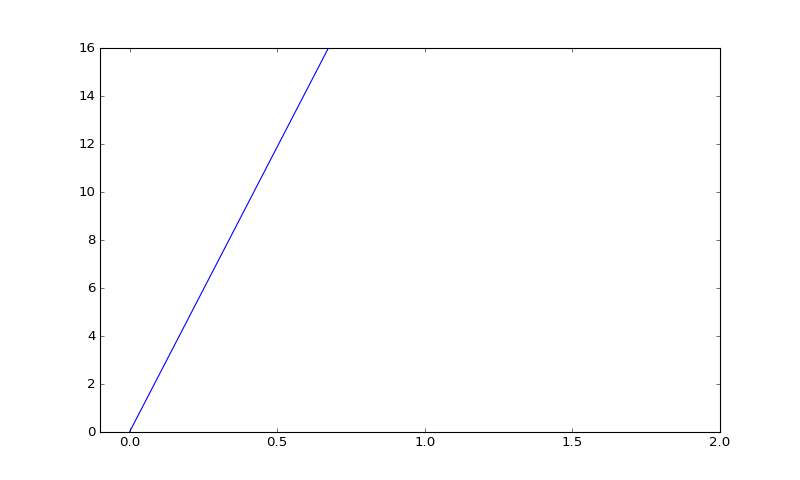

In [26]:
t.plot(0)


In [ ]:
print t.gcode()

In [ ]:
t.fluxTable()
t.fluxTable(sort='error')

In [ ]:
%reload_ext autoreload

# here's a filament transformer design using EI150 lamination
# I'm using this for a bench power supply
# 5.0V@5A, 6.3V@8A, 12.6V@6A

primary      = Winding.Winding('p',115.0,0.0,None)
secondary5a  = Winding.Winding('s',5.0 ,2.5,[50])
secondary5b  = Winding.Winding('s',5.0 ,2.5,[50])
secondary6a  = Winding.Winding('s',6.3 ,4.0,[50])
secondary6b  = Winding.Winding('s',6.3 ,4.0,[50])
secondary12a = Winding.Winding('s',12.6,3.0,[50])
secondary12b = Winding.Winding('s',12.6,3.0,[50])

t = Transformer.Transformer([primary,secondary6a,secondary6b,secondary12a,secondary12b,secondary5a,secondary5b],160,have=1)
t.coreLoss           = 0.8  # watts/lb, using AK DI-MAX M-13 at 12kG
t.isolationThickness = 0.003
t.wrappingThickness  = 0.005
t.insulationLayers   = 2

t.fluxDensity = t.fluxFind(bmax=100000,inc=500) # this scans through flux densities and finds minimal error for output voltage
t.compute()
t.report()


In [ ]:
print t.gcode()

In [ ]:
# grid bias transformer

primary   = Winding.Winding('p',115.0,0.0,None)
secondary = Winding.Winding('s',100.0 ,0.020,[50])

t = Transformer.Transformer([primary,secondary],7)
t.coreLoss           = 0.66 # watts/lbs, goes

t.fluxDensity = t.fluxFind(bmax=100000)
#t.fluxDensity = 90000
t.compute()
t.report()
t.fluxTable()
t.fluxTable(sort='error')

In [ ]:
# power transformer for a flyback tube output stage screen bias 200V

primary       = Winding.Winding('p',115.0,0.0,None)
secondary5    = Winding.Winding('s',5.0,2.0,None)
secondary6    = Winding.Winding('s',6.3,2.0,[50])
secondary200  = Winding.Winding('s',200.0,0.05,None)
secondary500  = Winding.Winding('s',500.0,0.100,[50])

t = Transformer.Transformer([secondary5,secondary6,primary,secondary500,secondary200],90)
t.circularMilsPerAmp = 700
t.coreLoss           = 0.88 # watts/lbs
t.wrappingThickness  = 0.05

t.fluxDensity = t.fluxFind()
t.compute()
t.report()

t.fluxTable()
t.fluxTable(sort='error')

To Do
* Calculate primary leakage inductance, see [Lee equation 33, p76](Lee p76.png).

$$L_S = \frac{10.6N^2MT(2nc + a)}{10^9n^2b}$$

* $L_S$ = leakage inductance of both windings in henrys, referred to the winding having N turns
* $MT$ = mean length of turn for the whole coil in inches
* $n$ = number of dielectrics between winding ( $n$ = 2 in Fig 57, see link above )
* $c$ = thickness of dielectric between winding in inches
* $a$ = winding height in inches
* $b$ = winding traverse in inches


* Calculate primary voltage drop using leakage inductance instead of efficiency estimate

* if tap lands at route direction change, tap doesn't show up on plot

* secondary VA calculation incorrect if secondary driving a rectifier, winding needs rectifier option